In [1]:
# check whether Li+ is increased in electrolyte with replenishment 

In [2]:
import pybamm as pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os; #import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
font = {'family' : 'Times New Roman',
        #'weight' : 'bold',
        'size'   : 15}
mpl.rc('font', **font)

In [3]:
from pybamm import constants, Parameter

def t_plus_tanh( c_e,c_EC, T  ):
    ratio = c_EC / c_e
    coff = 0.3
    return coff/2 + coff/2 *  pybamm.tanh((ratio-2.7705)*2)


In [4]:
V_max = 4.2;        V_min = 2.5;
Diff_SEI = 1.7e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 0.3 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * 1 )  

In [5]:
Model_sdiff = pybamm.lithium_ion.DFN(     
    options={"solvent diffusion": "none"     } )

have you come here?


Model_sdiff.variables.search('Electrolyte current density')

In [6]:
Model_ddiff = pybamm.lithium_ion.DFN(     
    options={"solvent diffusion": "EC w refill"} )

using EC w refill for Li+
using EC w refill for EC


In [7]:
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_EMC_FEC_19_1_Landesfeind2019";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':8e-19})

Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = 1.5e-9/1e2;
Para_0['Typical EC Lithium ion cross diffusivity [m2.s-1]'] =   1.5e-9/1e2
Para_0['EC transference number'] =    -1.4
Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  5E-12;
Para_0['Electrolyte diffusivity [m2.s-1]'] =   3E-10;


c_e_ddiff = Model_ddiff.variables["Electrolyte concentration [mol.m-3]"]
T_ddiff = Model_ddiff.variables["Cell temperature [K]"]
c_EC_ddiff = Model_ddiff.variables["EC concentration [mol.m-3]"]
Model_ddiff.variables["Cation transference number tanh"] = t_plus_tanh(
    c_e_ddiff,c_EC_ddiff, T_ddiff)


c_e_sdiff = Model_sdiff.variables["Electrolyte concentration [mol.m-3]"]
T_sdiff = Model_sdiff.variables["Cell temperature [K]"]
c_EC_sdiff = Model_sdiff.variables["EC concentration [mol.m-3]"]
Model_sdiff.variables["Cation transference number tanh"] = t_plus_tanh(
    c_e_sdiff ,c_EC_sdiff , T_sdiff )

t_plus_Landes = Para_0["Cation transference number"]
Model_ddiff.variables["Cation transference number Landes"] = t_plus_Landes(
    c_e_ddiff,c_EC_ddiff, T_ddiff)
Model_sdiff.variables["Cation transference number Landes"] = t_plus_Landes(
    c_e_sdiff,c_EC_sdiff, T_sdiff)

Para_0.search("diffusivity")
gamma_e_ec_Rio = Para_0.evaluate(Model_ddiff.param.gamma_e_ec_Rio)  
print(gamma_e_ec_Rio)

In [8]:
Sim_Landes_ddiff    = pybamm.Simulation(
    Model_ddiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)   
Sim_Landes_sdiff    = pybamm.Simulation(
    Model_sdiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)  
Sol_Landes_ddiff    = Sim_Landes_ddiff.solve();
Sol_Landes_sdiff    = Sim_Landes_sdiff.solve();


In [9]:
Para_0.update({'Cation transference number':t_plus_tanh})
Sim_tanh_ddiff    = pybamm.Simulation(
    Model_ddiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)  
Sim_tanh_sdiff    = pybamm.Simulation(
    Model_sdiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)  
Sol_tanh_ddiff    = Sim_tanh_ddiff.solve();
Sol_tanh_sdiff    = Sim_tanh_sdiff.solve();


In [10]:
Para_0.update({'Cation transference number':0.3})
Sim_0p3_ddiff    = pybamm.Simulation(
    Model_ddiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)  
Sim_0p3_sdiff    = pybamm.Simulation(
    Model_sdiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)  
Sol_0p3_ddiff    = Sim_0p3_ddiff.solve();
Sol_0p3_sdiff    = Sim_0p3_sdiff.solve();

In [11]:
Para_0.update({'Cation transference number':3e-4})
Sim_3e_4_ddiff    = pybamm.Simulation(
    Model_ddiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)  
Sim_3e_4_sdiff    = pybamm.Simulation(
    Model_sdiff, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)  
Sol_3e_4_ddiff    = Sim_3e_4_ddiff.solve();
Sol_3e_4_sdiff    = Sim_3e_4_sdiff.solve();

In [12]:
#  define variables
Li_eley_Landes_ddiff = Sol_Landes_ddiff["Total lithium in electrolyte [mol]"].entries
Li_part_Landes_ddiff = Sol_Landes_ddiff["Total lithium in particles [mol]"].entries
Li_tota_Landes_ddiff = Sol_Landes_ddiff["Total lithium [mol]"].entries
EC_eleySEI_Landes_ddiff = Sol_Landes_ddiff["Total EC in electrolyte and SEI [mol]"].entries
t_Landes_ddiff = Sol_Landes_ddiff["Time [h]"].entries

Li_eley_Landes_sdiff = Sol_Landes_sdiff["Total lithium in electrolyte [mol]"].entries
Li_part_Landes_sdiff = Sol_Landes_sdiff["Total lithium in particles [mol]"].entries
Li_tota_Landes_sdiff = Sol_Landes_sdiff["Total lithium [mol]"].entries
EC_eleySEI_Landes_sdiff = Sol_Landes_sdiff["Total EC in electrolyte and SEI [mol]"].entries
t_Landes_sdiff = Sol_Landes_sdiff["Time [h]"].entries

Li_eley_tanh_ddiff = Sol_tanh_ddiff["Total lithium in electrolyte [mol]"].entries
Li_part_tanh_ddiff = Sol_tanh_ddiff["Total lithium in particles [mol]"].entries
Li_tota_tanh_ddiff = Sol_tanh_ddiff["Total lithium [mol]"].entries
EC_eleySEI_tanh_ddiff = Sol_tanh_ddiff["Total EC in electrolyte and SEI [mol]"].entries
t_tanh_ddiff = Sol_tanh_ddiff["Time [h]"].entries

Li_eley_tanh_sdiff = Sol_tanh_sdiff["Total lithium in electrolyte [mol]"].entries
Li_part_tanh_sdiff = Sol_tanh_sdiff["Total lithium in particles [mol]"].entries
Li_tota_tanh_sdiff = Sol_tanh_sdiff["Total lithium [mol]"].entries
EC_eleySEI_tanh_sdiff = Sol_tanh_sdiff["Total EC in electrolyte and SEI [mol]"].entries
t_tanh_sdiff = Sol_tanh_sdiff["Time [h]"].entries

Li_eley_0p3_ddiff = Sol_0p3_ddiff["Total lithium in electrolyte [mol]"].entries
Li_part_0p3_ddiff = Sol_0p3_ddiff["Total lithium in particles [mol]"].entries
Li_tota_0p3_ddiff = Sol_0p3_ddiff["Total lithium [mol]"].entries
EC_eleySEI_0p3_ddiff = Sol_0p3_ddiff["Total EC in electrolyte and SEI [mol]"].entries
t_0p3_ddiff = Sol_0p3_ddiff["Time [h]"].entries

Li_eley_0p3_sdiff = Sol_0p3_sdiff["Total lithium in electrolyte [mol]"].entries
Li_part_0p3_sdiff = Sol_0p3_sdiff["Total lithium in particles [mol]"].entries
Li_tota_0p3_sdiff = Sol_0p3_sdiff["Total lithium [mol]"].entries
EC_eleySEI_0p3_sdiff = Sol_0p3_sdiff["Total EC in electrolyte and SEI [mol]"].entries
t_0p3_sdiff = Sol_0p3_sdiff["Time [h]"].entries

Li_eley_3e_4_sdiff = Sol_3e_4_sdiff["Total lithium in electrolyte [mol]"].entries
Li_part_3e_4_sdiff = Sol_3e_4_sdiff["Total lithium in particles [mol]"].entries
Li_tota_3e_4_sdiff = Sol_3e_4_sdiff["Total lithium [mol]"].entries
EC_eleySEI_3e_4_sdiff = Sol_3e_4_sdiff["Total EC in electrolyte and SEI [mol]"].entries
t_3e_4_sdiff = Sol_3e_4_sdiff["Time [h]"].entries

Li_eley_3e_4_ddiff = Sol_3e_4_ddiff["Total lithium in electrolyte [mol]"].entries
Li_part_3e_4_ddiff = Sol_3e_4_ddiff["Total lithium in particles [mol]"].entries
Li_tota_3e_4_ddiff = Sol_3e_4_ddiff["Total lithium [mol]"].entries
EC_eleySEI_3e_4_ddiff = Sol_3e_4_ddiff["Total EC in electrolyte and SEI [mol]"].entries
t_3e_4_ddiff = Sol_3e_4_ddiff["Time [h]"].entries

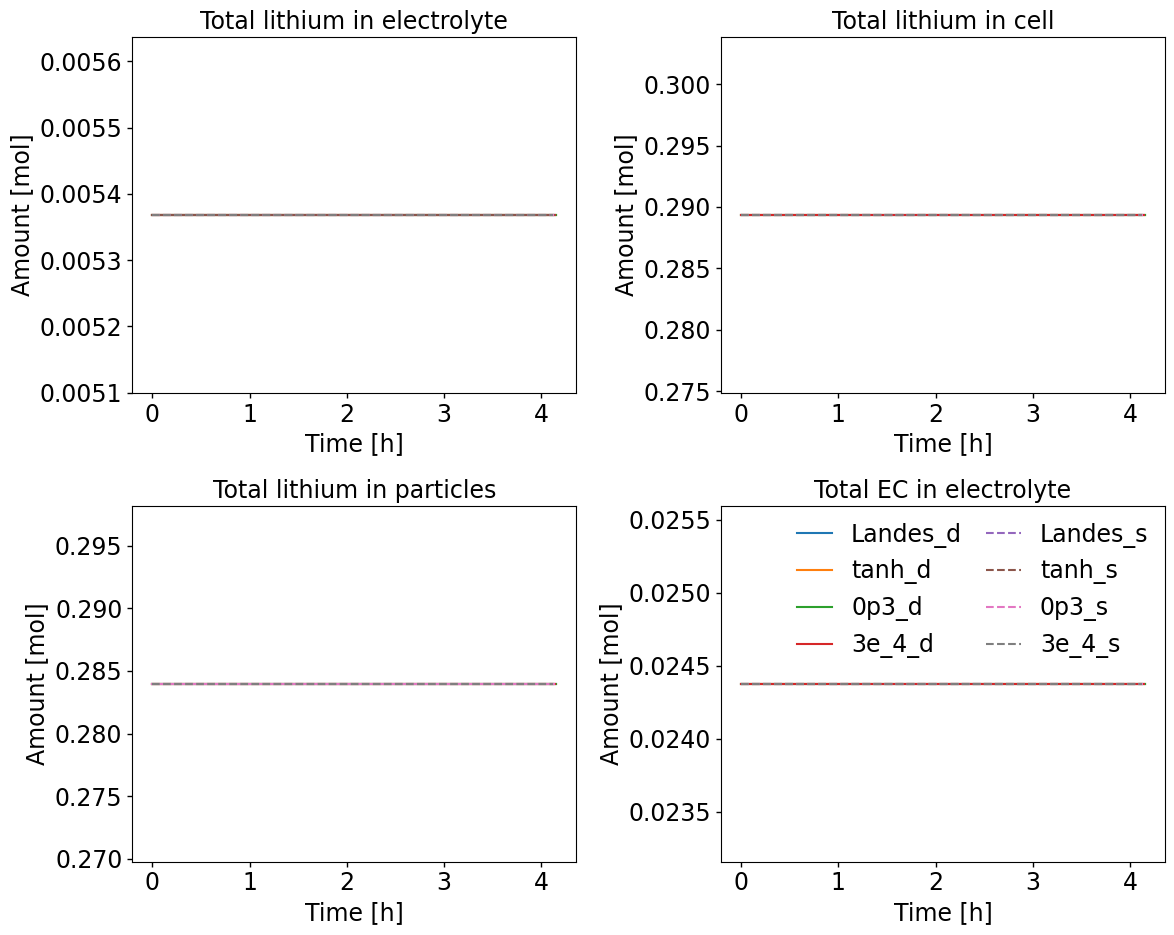

In [13]:
fig, axs = plt.subplots(2,2, figsize=(12,9.6),tight_layout=True)
axs[0,0].plot(t_Landes_ddiff, Li_eley_Landes_ddiff,'-',label="Landes_d")
axs[0,0].plot(t_tanh_ddiff, Li_eley_tanh_ddiff,'-',label="tanh_d")
axs[0,0].plot(t_0p3_ddiff, Li_eley_0p3_ddiff,'-',label="0p3_d")
axs[0,0].plot(t_3e_4_ddiff, Li_eley_3e_4_ddiff,'-',label="3e_4_d")
axs[0,0].plot(t_Landes_sdiff, Li_eley_Landes_sdiff,'--',label="Landes_s")
axs[0,0].plot(t_tanh_sdiff, Li_eley_tanh_sdiff,'-',label="tanh_s")
axs[0,0].plot(t_0p3_sdiff, Li_eley_0p3_sdiff,'--',label="0p3_s")
axs[0,0].plot(t_3e_4_sdiff, Li_eley_3e_4_sdiff,'--',label="3e_4_s")
Min_plt = min(Li_eley_Landes_ddiff); Max_plt = max(Li_eley_Landes_ddiff);
axs[0,0].set_ylim(Min_plt*0.95,Max_plt*1.05)


axs[1,0].plot(t_Landes_ddiff, Li_part_Landes_ddiff,'-',label="Landes_d")
axs[1,0].plot(t_tanh_ddiff, Li_part_tanh_ddiff,'-',label="tanh_d")
axs[1,0].plot(t_0p3_ddiff, Li_part_0p3_ddiff,'-',label="0p3_d")
axs[1,0].plot(t_3e_4_ddiff, Li_part_3e_4_ddiff,'-',label="3e_4_d")
axs[1,0].plot(t_Landes_sdiff, Li_part_Landes_sdiff,'--',label="Landes_s")
axs[1,0].plot(t_tanh_sdiff, Li_part_tanh_sdiff,'--',label="tanh_s")
axs[1,0].plot(t_0p3_sdiff, Li_part_0p3_sdiff,'-',label="0p3_s")
axs[1,0].plot(t_3e_4_sdiff, Li_part_3e_4_sdiff,'--',label="3e_4_s")
Min_plt = min(Li_part_3e_4_ddiff); Max_plt = max(Li_part_3e_4_ddiff);
axs[1,0].set_ylim(Min_plt*0.95,Max_plt*1.05)

axs[0,1].plot(t_Landes_ddiff, Li_tota_Landes_ddiff,'-',label="Landes_d")
axs[0,1].plot(t_tanh_ddiff, Li_tota_tanh_ddiff,'-',label="tanh_d")
axs[0,1].plot(t_0p3_ddiff, Li_tota_0p3_ddiff,'-',label="0p3_d")
axs[0,1].plot(t_3e_4_ddiff, Li_tota_3e_4_ddiff,'-',label="3e_4_d")
axs[0,1].plot(t_Landes_sdiff, Li_tota_Landes_sdiff,'--',label="Landes_s")
axs[0,1].plot(t_tanh_sdiff, Li_tota_tanh_sdiff,'--',label="tanh_s")
axs[0,1].plot(t_0p3_sdiff, Li_tota_0p3_sdiff,'--',label="0p3_s")
axs[0,1].plot(t_3e_4_sdiff, Li_tota_3e_4_sdiff,'--',label="3e_4_s")
Min_plt = min(Li_tota_Landes_ddiff); Max_plt = max(Li_tota_Landes_ddiff);
axs[0,1].set_ylim(Min_plt*0.95,Max_plt*1.05)

axs[1,1].plot(t_Landes_ddiff, EC_eleySEI_Landes_ddiff,'-',label="Landes_d")
axs[1,1].plot(t_tanh_ddiff, EC_eleySEI_tanh_ddiff,'-',label="tanh_d")
axs[1,1].plot(t_0p3_ddiff, EC_eleySEI_0p3_ddiff,'-',label="0p3_d")
axs[1,1].plot(t_3e_4_ddiff, EC_eleySEI_3e_4_ddiff,'-',label="3e_4_d")
axs[1,1].plot(t_Landes_sdiff, EC_eleySEI_Landes_sdiff,'--',label="Landes_s")
axs[1,1].plot(t_tanh_sdiff, EC_eleySEI_tanh_sdiff,'--',label="tanh_s")
axs[1,1].plot(t_0p3_sdiff, EC_eleySEI_0p3_sdiff,'--',label="0p3_s")
axs[1,1].plot(t_3e_4_sdiff, EC_eleySEI_3e_4_sdiff,'--',label="3e_4_s")
Min_plt = min(EC_eleySEI_0p3_sdiff); Max_plt = max(EC_eleySEI_0p3_sdiff);
axs[1,1].set_ylim(Min_plt*0.95,Max_plt*1.05)

axs[0,0].set_title("Total lithium in electrolyte",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1,0].set_title("Total lithium in particles",   fontdict={'family':'DejaVu Sans','size':fs})
axs[0,1].set_title("Total lithium in cell",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1,1].set_title("Total EC in electrolyte",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    for j in range(0,2):
        axs[i,j].set_xlabel("Time [h]",   fontdict={'family':'DejaVu Sans','size':fs})
        axs[i,j].set_ylabel("Amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs})
        labels = axs[i,j].get_xticklabels() + axs[i,j].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
        axs[i,j].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;

axs[1,1].legend(prop={'family':'DejaVu Sans','size':fs},loc='best',ncol=2,frameon=False,
    markerscale=1,borderpad=0.2,handlelength=1.5,columnspacing=1)    


In [14]:
label = ["Landes_d","Landes_s","tanh_d","tanh_s",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "Current [A]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    #"Loss of capacity to SEI [A.h]",
    "Electrolyte flux [mol.m-2.s-1]",
    "EC flux [mol.m-2.s-1]",
    #"Porosity times EC concentration",
    #"Porosity times concentration",
    "Cation transference number tanh",
    "Cation transference number Landes",
]
quick_plot = pybamm.QuickPlot([
    Sol_Landes_ddiff,Sol_Landes_sdiff,Sol_tanh_ddiff,Sol_tanh_sdiff
    ], output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=2,
    ) #     spatial_unit='mm',figsize = (330,140)
quick_plot.dynamic_plot();
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R4/'; 
Target  = 'a0_case3_doublediffusion_noSEI/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);
output_filename = BasicPath + Target + '/t_0+_func.gif'

quick_plot.create_gif(
    number_of_images=10, duration=1,output_filename=output_filename)

interactive(children=(FloatSlider(value=0.0, description='t', max=4.149657994093924, step=0.04149657994093924)…

In [18]:
label = ["0.3 d","0.3 s","3e-4 d","3e-4 s",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "Current [A]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    #"Loss of capacity to SEI [A.h]",
    "Electrolyte flux [mol.m-2.s-1]",
    "EC flux [mol.m-2.s-1]",
    #"Porosity times EC concentration",
    #"Porosity times concentration",  0p3 3e_4_
    #"Cation transference number 3e_4",
    #"Cation transference number 0p3",
]
quick_plot = pybamm.QuickPlot([
    Sol_0p3_ddiff,Sol_0p3_sdiff,Sol_3e_4_ddiff,Sol_3e_4_sdiff
    ], output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=2,
    ) #     spatial_unit='mm',figsize = (330,140)
quick_plot.dynamic_plot();
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R4/'; 
Target  = 'a0_case3_doublediffusion_noSEI/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);
output_filename = BasicPath + Target + '/t_0+_constant.gif'

quick_plot.create_gif(
    number_of_images=10, duration=1,output_filename=output_filename)

interactive(children=(FloatSlider(value=0.0, description='t', max=4.152420909076213, step=0.041524209090762126…

In [15]:
label = ["double diffusion","single diffusion",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    #"Total EC in electrolyte [mol]",
    "Negative electrode SEI interfacial current density [A.m-2]",
    #"Loss of capacity to SEI [A.h]",
    #"Loss of lithium to SEI [mol]",
            
]
quick_plot = pybamm.QuickPlot([Sol_tanh_ddiff,Sol_tanh_sdiff], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=4.149657994093924, step=0.04149657994093924)…

In [16]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "Negative electrode SEI interfacial current density [A.m-2]",
    "Loss of capacity to SEI [A.h]",
    "Loss of lithium to SEI [mol]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

NameError: name 'Sol_0' is not defined

In [ ]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    "Total lithium in electrolyte [mol]",   
    "Total lithium lost from electrolyte [mol]",
    "Total lithium [mol]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();
